# Import data

In [1]:
import numpy as np
import pandas as pd

import psycopg2
from sqlalchemy import create_engine 

import re
from tqdm.notebook import tqdm

from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    Doc
)

In [2]:
username = '...'
password = '...'
host = '...'
port = '...'
database = '...'

conn_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'
        
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

df = pd.read_sql_query('SELECT * FROM clean_data', conn)
conn.close()

print(df.shape)

(29899, 8)


# Create verification dict

In [ ]:
'''
Источники:
    Компании: 
    - база индекса широкого рынка (MOEXBMI): https://fin-plan.org/lk/index/MOEXBMI/
    - база 10 отраслевых индексов: https://www.moex.com/ru/index/MOEXOG

    Отрасли: 
    - согласно 10 сущствующим отраслевым индексам: https://www.moex.com/ru/index/MOEXOG

    Глобально:
    - гос сущности: common sense :)
    - политики: топ 50 из http://www.apecom.ru/projects/item.php?SECTION_ID=100&ELEMENT_ID=8915
'''

'''
Формы в словаре:
    Компании: 
    - стандартное название
    - сокращенное название
    - название на английском языке
    - тикет на рынке

    Отрасли: 
    - определяется принадлежностью компании к определенной отрасли

    Глобально: 
    - Гос сущности: частоупотребимые вариации (i.e. ЦБ, центробанк, центральный банк России и т.д.)
    - Политики: фамилии
'''


In [3]:
companies = {
    # One
    'SBER': r'\s(?:сбербанк|сбер|sber|sberbank)\s',
    'LKOH': r'\s(:?лукойл|lukoil|lkoh)\s',
    'GAZP': r'\s(:?газпром|gazprom|gazp)\s',
    'GMKN': r'\s(:?норильский никель|норникель|gmkn|nornikel|гмкнорник|норник)\s',
    'NVTK': r'\s(:?новатэк|novatek|nvtk)\s',
    'YNDX': r'\s(:?яндекс|yandex|yndx|янд)\s',
    'ROSN': r'\s(:?роснефть|rosn|rosneft)\s',
    'TATN': r'\s(:?татнефть|татнфт|tatn|tatneft)\s',
    'MGNT': r'\s(:?магнит|mgnt|magnit)\s',
    'TCSG': r'\s(:?tcg|tcs|tcsg|тиньк|тинькофф|тиньков)\s',
    # Two
    'SNGS': r'\s(:?сургутнефтегаз|сургнфгз|sngs|surgutneftegas)\s',
    'TRNF': r'\s(:?транснефть|транснф|trnf|transneft)\s',
    'PLZL': r'\s(:?полюс|plzl|polus zoloto|polus)\s',
    'CHMF': r'\s(:?северсталь|севст|chmf|severstal)\s',
    'FIVE': r'\s(:?x5|five)\s',
    'NLMK': r'\s(:?нлмк|nlmk|новолипецкий металлургический комбинат|новолипецкий)\s',
    'MTSS': r'\s(:?мтс|мобильные телесистемы|mts|mtss)\s',
    # Three
    'PHOR': r'\s(:?фосагро|phor|phosagro)\s',
    'POLY': r'\s(:?полиметалл|polymetal|poly)\s',
    'ALRS': r'\s(:?алроса|alrs|alrosa)\s',
    'IRAO': r'\s(:?интеррао|интер рао|irao|inter rao|interrao)\s',
    'OZON': r'\s(:?ozon|озон)\s',
    'MAGN': r'\s(:?магнитогорский металлургический комбинат|ммк|magn|mmk)\s',
    'VTBR': r'\s(:?втб|vtb|vtbr)\s',
    'HHRU': r'\s(:?headhunter|hh|hhru|хэдхантер|хэдхантэр)\s',
    'RUAL': r'\s(:?русал|rusal|rual)\s',
    'PIKK': r'\s(:?пик|pikk|pik)\s',
    # Four
    'ENPG': r'\s(:?эн\+ груп|en\+ group|эн\+|en\+|эн\+груп|enpg|en\+group)\s',
    'RTKM': r'\s(:?ростелеком|ростел|rostel|rostelecom|rtkm)\s',
    'MTLR': r'\s(:?мечел|mechel|mltr)\s',
    'FIXP': r'\s(:?fix|fix price|fixp|фикс прайс)\s',
    'GLTR': r'\s(:?globaltrans|gltr|глобалтранс|global trans|глобал транс)\s',
    'CBOM': r'\s(:?московский кредитный банк|мкб|mkb|московский банк|cbom)\s',
    'HYDR': r'\s(:?русгидро|hydr|rushydro)\s',
    'AGRO': r'\s(:?русагро|agro|rusagro)\s',
    'AFKS': r'\s(:?афк система|афк|afks|afk|afk system)\s',
    # Five
    'BANE': r'\s(:?башнефт|башнефть|bane|bashneft)\s',
    'KAZT': r'\s(:?куйбазот|куйбышевазот|kazt)\s',
    'FLOT': r'\s(:?совкомфлот|sovkomflot|flot)\s',
    'FEES': r'\s(:?фск россети|fees|fsk rosseti)\s',
    'VSMO': r'\s(:?всмпо-авсм|всмпо|авсм|vsmpo|avsm|vsmpo-avsm|vsmo)\s',
    'AFLT': r'\s(:?аэрофлот|aflt|aeroflot)\s',
    'AKRN': r'\s(:?акрон|akrn|akron)\s',
    'SELG': r'\s(:?селигдар|selg|seligdar)\s',
    'NKNC': r'\s(:?нкнх|нижнекамскнефтехим|nknc)\s',
    # Six
    'BSPB': r'\s(:?бсп|банк санкт-петербург|банк спб|bspb|bsp)\s',
    'LENT': r'\s(:?лента|lenta|lent)\s',
    'GEMC': r'\s(:?gemc|united medical)\s',
    'KZOS': r'\s(:?казаньоргсинтез|оргсинт|kzos|kazanorgsintez)\s',
    'MGTS': r'\s(:?мгтс|mgts|московская городская телефонная сеть)\s',
    'MSNG': r'\s(:?мосэнерго|\+мосэнерго|mosenergo|\+mosenergo|msng)\s',
    'SMLT': r'\s(:?гк самолет|smlt|gk samolet)\s',
    'NMTP': r'\s(:?нмтп|nmtp|новороссийский морской торговый порт)\s',
    'UPRO': r'\s(:?юнипро|upro|unipro)\s',
    'FESH': r'\s(:?двмп|fesh|дальневосточное морское пароходство|dvmp)\s',
    # Seven
    'BELU': r'\s(:?новабев|belu|novabev)\s',
    'QIWI': r'\s(:?qiwi|киви|iqiwi|айкиви)\s',
    'MDMG': r'\s(:?mdmg|md medical)\s',
    'POSI': r'\s(:?iпозитив|группа позитив|ipositiv|positiv|posi)\s',
    'RASP': r'\s(:?распадская|raspadskaya|rasp)\s',
    'LSRG': r'\s(:?лср|группа лср|lsr|lsrg)\s',
    'LSNG': r'\s(:?россети ленэнерго|ленэнерго|lenenergo|lsng)\s',
    'SGZH': r'\s(:?сегежа|segezha|sgzh)\s',
    # Eight
    'RSTI': r'\s(:?rsti|российские сети|россети|rosseti)\s',
    'OGKB': r'\s(:?огк-2|ogk-2|ogkb)\s',
    'AQUA': r'\s(:?инарктика|aqua|inarctica)\s',
    'ETLN': r'\s(:?etalon|etln|группа эталон|эталон)\s',
    'RENI': r'\s(:?ренессанс страхование|группа ренессанс|reni)\s',
    'NKHP': r'\s(:?нкхп|nkhp|новороссийский комбинат хлебопродуктов)\s',
    'MRKP': r'\s(:?рсетицп|россети центр и приволжье|mrkp)\s',
    'MRKC': r'\s(:?россцентр|россети центр|mrkc)\s',
    'MVID': r'\s(:?м\.видео|мвидео|mvideo|m\.video|mvid)\s',
    'ELFV': r'\s(:?эл5-энерго|эл5энер|эл5|el5ener|el5-energo|el5|elfv)\s',
    # Nine
    'TGKA': r'\s(:?тгк-1|tgka|tgk-1)\s',
    'RNFT': r'\s(:?русснфт|русснефть|rnft|russneft|russnft)\s',
    'APTK': r'\s(:?аптеки36и6|аптечная сеть 36,6|aptk)\s',
    'MSRS': r'\s(:?рсетимр|россети московский регион|msrs|rsetimr)\s',
    'SFIN': r'\s(:?эсэфай|sfi|сафмар|sfin)\s',
    'MRKU': r'\s(:?россети урал|россети ур|rosseti ural|rosseti ur|mrku)\s',
    'SVAV': r'\s(:?соллерс|sollers|svav)\s',
    'CIAN': r'\s(:?циан|cian)\s',
    'TGKB': r'\s(:?тгк-2|tgkb|tgk-2)\s',
    # Ten
    'DVEC': r'\s(:?дэк|дальневосточная энергетическая компания|dec|dvec)\s',
    'RKKE': r'\s(:?энергияркк|ркк энергия|rkk energia|rkk energiya|rkke)\s',
    'MRKZ': r'\s(:?рсетисз|россети северо-запад|mrkz)\s',
    'WUSH': r'\s(:?iвушхолднг|вуш|wush|whoosh)\s',
    'TTLK': r'\s(:?таттел|таттелеком|ttlk|tattelecom|tattel)\s',
    'MRKV': r'\s(:?рсетвол|россети волга|mrkv)\s',
    'ABIO': r'\s(:?iартген|артген|abio|artgen)\s',
    'CHMK': r'\s(:?чмк|челябинский металлургический комбинат|chmk)\s',
    'OKEY': r"\s(:?okey|o'key|окей|о'кей)\s",
    
    # More
    'VKCO': r'\s(:?вк|vk|вконтакте|vkontakte|в контакте|v kontakte|vkco)\s'
}

industries = {
    # Нефть и газ
    'MOEXOG': ['BANE', 'GAZP', 'LKOH', 'NVTK', 'RNFT', 'ROSN', 'SNGS', 'TATN', 'TRNF'],
    # Электроэнергетики
    'MOEXEU': ['IRAO', 'HYDR', 'FEES', 'MSNG', 'UPRO', 'LSNG', 'RSTI', 'OGKB', 'MRKP', 'MRKC', 'ELFV', 
               'TGKA', 'MSRS', 'MRKU', 'TGKB', 'DVEC', 'MRKZ', 'MRKV'],
    # Телекоммуникации
    'MOEXTL': ['MTSS', 'RTKM', 'MGTS', 'TTLK'],
    # Металлы и добыча
    'MOEXMM': ['GMKN', 'PLZL', 'CHMF', 'NLMK', 'POLY', 'ALRS', 'MAGN', 'RUAL', 'ENPG', 'MTLR', 'VSMO',
              'SELG', 'RASP', 'SGZH', 'CHMK'],
    # Финансы
    'MOEXFN': ['SBER', 'TCSG', 'VTBR', 'CBOM', 'BSPB', 'QIWI', 'RENI', 'SFIN', 'AFKS'],
    # Потребительский сектор
    'MOEXCN': ['MGNT', 'FIVE', 'FIXP', 'AGRO', 'GEMC', 'LENT', 'BELU', 'MDMG', 'AQUA', 'MVID', 'APTK',
              'SVAV', 'WUSH', 'ABIO', 'OKEY'],
    # Химия и нефтехимия
    'MOEXCH': ['PHOR', 'KAZT', 'AKRN', 'NKNC', 'KZOS'],
    # Транспорт
    'MOEXTN': ['GLTR', 'FLOT', 'AFLT', 'NMTP', 'FESH', 'NKHP', 'RKKE'],
    # Информационные технологии
    'MOEXIT': ['CIAN', 'HHRU', 'OZON', 'POSI', 'VKCO', 'YNDX'],
    # Строительные компании
    'MOEXRE': ['ETLN', 'LSRG', 'PIKK', 'SMLT'],
}

politicians = [
    # One
    r'путин',
    r'мишустин',
    r'вайно',
    r'медведев',
    r'собянин',
    r'кириенко',
    r'лавров',
    r'патрушев',
    r'шойгу',
    r'миллер',
    # Two
    r'сечин',
    r'силуанов',
    r'громов',
    r'набиуллина',
    r'турчак',
    r'бортников',
    r'володин',
    r'песков',
    r'бастрыкин',
    r'белоусов',
    # Three
    r'нарышкин',
    r'чемезов',
    r'матвиенко',
    r'греф',
    r'золотов',
    r'колокольцев',
    r'тимченко',
    r'ковальчук',
    r'патриарх',
    r'хуснуллин',
    # Four
    r'борисов',
    r'голикова',
    r'новак',
    r'герасимов',
    r'костин',
    r'козак',
    r'патрушев',
    r'чернышенко',
    r'ярин',
    r'мантуров',
    # Five
    r'трутнев',
    r'григоренко',
    r'левитин',
    r'краснов',
    r'усманов',
    r'васильев',
    r'оверчук',
    r'ротенберг',
    r'харичев',
    r'чиханчин',
]

federal_instances = {
    "ЦБ": r'\s(?:цб|центральный банк|центробанк)\s',
    
    "МинФин": r'\s(?:министерство финансов|минфин)\s',
    
    "ФНС": r'\s(?:федеральная налоговая служба|фнс|налоговая служба|налоговый департамент|налоговое ведомство|налоговое управление)\s',
    
    "ФСФМ": r'\s(?:федеральная служба финансового мониторинга|финмониторинг|федеральная служба по финансовым операциям|фсфм)\s',
    
    "ПФР": r'\s(?:пенсионный фонд|пфр|фонд пенсионного обеспечения|фонд соцзащиты)\s',
    
    "ФНБ": r'\s(?:фонд национального благосостояния|фнб|фонд стабилизации|фонд)\s',
    
    "ФК": r'\s(?:казначейство|фк|финансовая служба)\s',
    
    "ММВБ": r'\s(?:ммвб|московская биржа|moex|rts|российская торговая система|биржевой индекс)\s',
}

# Extract NER

In [4]:
# Natasha <3
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

ner_tagger = NewsNERTagger(emb)

In [5]:
docs_lst = [Doc(text) for text in df['body']]

for doc in tqdm(docs_lst):
    doc.segment(segmenter)
    
    doc.tag_morph(morph_tagger)
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    
    doc.tag_ner(ner_tagger)
    
    for span in doc.spans:
        span.normalize(morph_vocab)

  0%|          | 0/29899 [00:00<?, ?it/s]

In [6]:
tokens_lst = []

for el in docs_lst:
    tokens_lst.append(list(set([i.normal for i in el.spans])))

# Filter NE found

In [72]:
def filter_ne(lst: list, filt: dict) -> None:
    for tokens in tqdm(tokens_lst):
        help_lst = []
        for key, pattern in filt.items():
            obj = re.search(pattern, '   '.join(tokens).lower())
            if obj:
                help_lst.append(key)

        lst.append(help_lst)

In [73]:
companies_lst = []
fed_lst = []
polit_lst = []

filter_ne(companies_lst, companies)
filter_ne(fed_lst, federal_instances)
filter_ne(polit_lst, {f'политик_{i+1}': rf'{polit}' for i, polit in enumerate(politicians)})
    
# print(len([lst for lst in companies_lst if (len(lst) > 0) and (len(lst) <= 10)]))
# print(len([lst for lst in fed_lst if len(lst) > 0]))
# print(len([lst for lst in polit_lst if len(lst) > 0]))

  0%|          | 0/29899 [00:00<?, ?it/s]

  0%|          | 0/29899 [00:00<?, ?it/s]

  0%|          | 0/29899 [00:00<?, ?it/s]

In [74]:
data = pd.DataFrame(columns=[*df.columns, 'companies'])
rows_to_insert = []

for i in tqdm(range(len(df))):
    if (len(companies_lst[i]) != 0) or (len(fed_lst[i]) != 0) or (len(polit_lst[i]) != 0):
        rows_to_insert.append(
            {
                'website': df.loc[i, 'website'], 
                'section': df.loc[i, 'section'],
                'url': df.loc[i, 'url'],
                'header': df.loc[i, 'header'],
                'body': df.loc[i, 'body'],
                'tags': df.loc[i, 'tags'],
                'body_length': df.loc[i, 'body_length'],
                'datetime': df.loc[i, 'datetime'],
                'companies': companies_lst[i],
                
            }
        ) 

data = pd.concat([data, pd.DataFrame(rows_to_insert)], ignore_index=True)

  0%|          | 0/29899 [00:00<?, ?it/s]

In [75]:
print(data.shape)
data.head()

(13326, 9)


,website,section,url,header,body,tags,body_length,datetime,companies
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,[SBER]
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00,[]
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00,"[SBER, LKOH, GAZP, GMKN, NVTK, YNDX, ROSN, TAT..."
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00,[]
4,Kommersant,Финансы,https://www.kommersant.ru/doc/5757823,"Индекс Мосбиржи растет на 0,5% на первой торго...",Индекс Московской биржи на открытии торгов рас...,None,598,2023-01-03 10:31:00,[]


# Final Datasets

## Companies dataset

In [64]:
comp_df = data[data['companies'].apply(lambda x: len(x) != 0)].reset_index()

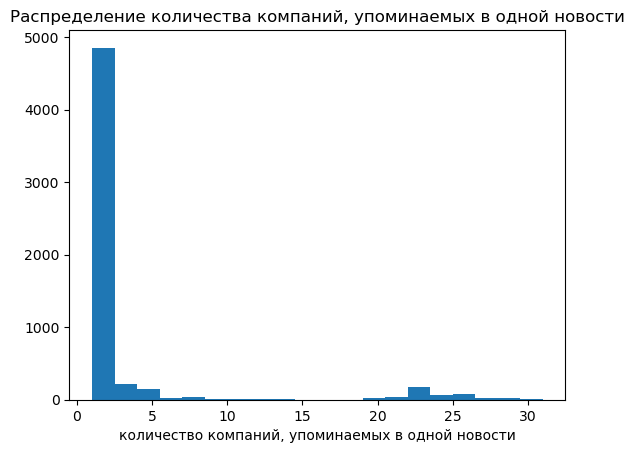

In [65]:
import matplotlib.pyplot as plt

lst_len = []
for i in range(len(comp_df)):
    lst_len.append(len(comp_df.loc[i,'companies']))

plt.hist(lst_len, bins=20)
plt.title('Распределение количества компаний, упоминаемых в одной новости')
plt.xlabel('количество компаний, упоминаемых в одной новости')
plt.show()

> **Комментарий**: Можно заметить, что у нас есть новости, где упоминается по 20-30 компаний, эти новости являются обзорами рынка и для наших целей не подходят, поэтому в наш финальный датасет по компаниям и отраслям мы их включать не будем

In [66]:
final_comp_df = pd.DataFrame(columns=[*df.columns, 'company'])
rows_to_insert = []

for i in tqdm(range(len(comp_df))):
    if len(comp_df.loc[i,'companies']) <= 10:
        for company in comp_df.loc[i,'companies']:
            rows_to_insert.append(
                {
                    'website': comp_df.loc[i, 'website'], 
                    'section': comp_df.loc[i, 'section'],
                    'url': comp_df.loc[i, 'url'],
                    'header': comp_df.loc[i, 'header'],
                    'body': comp_df.loc[i, 'body'],
                    'tags': comp_df.loc[i, 'tags'],
                    'body_length': comp_df.loc[i, 'body_length'],
                    'datetime': comp_df.loc[i, 'datetime'],
                    'company': company,

                }
            )

final_comp_df = pd.concat([final_comp_df, pd.DataFrame(rows_to_insert)], ignore_index=True)

  0%|          | 0/5746 [00:00<?, ?it/s]

In [67]:
print(final_comp_df.shape)
final_comp_df.head(5)

(7542, 9)


,website,section,url,header,body,tags,body_length,datetime,company
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,SBER
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,GAZP
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,ROSN
3,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879947,"""Соллерс"" возобновил после новогодних каникул ...","- Российская автомобилестроительная группа ""...","['Соллерс', 'Соллерс Алабуга', 'Татарстан']",2243,2023-01-09 12:28:00,SVAV
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,SBER


## Industries dataset

In [68]:
ind_df = pd.DataFrame(columns=[*df.columns, 'industry'])
rows_to_insert = []

for i in tqdm(range(len(comp_df))):
    if len(comp_df.loc[i,'companies']) <= 10:  
        ind_lst = []
        for company in comp_df.loc[i,'companies']: 
            for industry, ind_companies in industries.items():
                if company in ind_companies and industry not in ind_lst:
                    ind_lst.append(industry)

                    rows_to_insert.append(
                        {
                        'website': comp_df.loc[i, 'website'], 
                        'section': comp_df.loc[i, 'section'],
                        'url': comp_df.loc[i, 'url'],
                        'header': comp_df.loc[i, 'header'],
                        'body': comp_df.loc[i, 'body'],
                        'tags': comp_df.loc[i, 'tags'],
                        'body_length': comp_df.loc[i, 'body_length'],
                        'datetime': comp_df.loc[i, 'datetime'],
                        'industry': industry,
                        }
                    ) 
                
ind_df = pd.concat([ind_df, pd.DataFrame(rows_to_insert)], ignore_index=True)

  0%|          | 0/5746 [00:00<?, ?it/s]

In [69]:
print(ind_df.shape)
ind_df.head(5)

(6228, 9)


,website,section,url,header,body,tags,body_length,datetime,industry
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,MOEXFN
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,MOEXOG
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,MOEXOG
3,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879947,"""Соллерс"" возобновил после новогодних каникул ...","- Российская автомобилестроительная группа ""...","['Соллерс', 'Соллерс Алабуга', 'Татарстан']",2243,2023-01-09 12:28:00,MOEXCN
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXFN


## Global dataset

In [70]:
global_df = data.drop(['companies'], axis=1).copy()

In [71]:
print(global_df.shape)
global_df.head(5)

(13326, 8)


,website,section,url,header,body,tags,body_length,datetime
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00
4,Kommersant,Финансы,https://www.kommersant.ru/doc/5757823,"Индекс Мосбиржи растет на 0,5% на первой торго...",Индекс Московской биржи на открытии торгов рас...,None,598,2023-01-03 10:31:00


# Export data

In [27]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
final_comp_df.to_sql('companies_tickets', con=conn, if_exists='replace', index=False) 
conn.close()

In [28]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
ind_df.to_sql('industries_tickets', con=conn, if_exists='replace', index=False) 
conn.close()

In [29]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
global_df.to_sql('global_tickets', con=conn, if_exists='replace', index=False) 
conn.close()

Self check:

In [33]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM companies_tickets', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(7542, 9)


,website,section,url,header,body,tags,body_length,datetime,company
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,SBER
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,GAZP
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,ROSN
3,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879947,"""Соллерс"" возобновил после новогодних каникул ...","- Российская автомобилестроительная группа ""...","['Соллерс', 'Соллерс Алабуга', 'Татарстан']",2243,2023-01-09 12:28:00,SVAV
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,SBER


In [35]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM industries_tickets', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(6228, 9)


,website,section,url,header,body,tags,body_length,datetime,industry
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,MOEXFN
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,MOEXOG
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,MOEXOG
3,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879947,"""Соллерс"" возобновил после новогодних каникул ...","- Российская автомобилестроительная группа ""...","['Соллерс', 'Соллерс Алабуга', 'Татарстан']",2243,2023-01-09 12:28:00,MOEXCN
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXFN


In [36]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM global_tickets', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(13326, 8)


,website,section,url,header,body,tags,body_length,datetime
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00
4,Kommersant,Финансы,https://www.kommersant.ru/doc/5757823,"Индекс Мосбиржи растет на 0,5% на первой торго...",Индекс Московской биржи на открытии торгов рас...,None,598,2023-01-03 10:31:00
